# PINN: Navier Stokes equation, flow in slot

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

## neural net

In [7]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(3, 20)
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 20)
        self.l6=nn.Linear(20, 20)
        self.l7=nn.Linear(20, 20)
        self.l8=nn.Linear(20, 20)
        self.l9=nn.Linear(20, 20)
        self.l10=nn.Linear(20, 2)
        
    def forward(self, t,x,y):
        txy = torch.cat([t,x,y],axis=1)
        out=torch.tanh(self.l1(txy)) #does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        #out=torch.tanh(self.l3(out))
        #out=torch.tanh(self.l4(out))
        #out=torch.tanh(self.l5(out))
        #out=torch.tanh(self.l6(out))
        #out=torch.tanh(self.l7(out))
        out=torch.tanh(self.l8(out))
        out=torch.tanh(self.l9(out))
        out=self.l10(out)
        return out

def f(net,t,x,y): #physics loss
    psip=net(t,x,y)
    psi=psip[:,0]
    p=psip[:,1]
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0] #velocity in x direction
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0] #velocity in y direction
    ux = torch.autograd.grad(u.sum(), x, create_graph=True)[0] #du/dx
    uy = torch.autograd.grad(u.sum(), y, create_graph=True)[0] #du/dy
    vx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    vy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    uxx = torch.autograd.grad(ux.sum(), x, create_graph=True)[0] #d^2u/dx^2
    uyy = torch.autograd.grad(uy.sum(), y, create_graph=True)[0]
    vxx = torch.autograd.grad(vx.sum(), x, create_graph=True)[0]
    vyy = torch.autograd.grad(vy.sum(), y, create_graph=True)[0]
    px = torch.autograd.grad(p.sum(), x, create_graph=True)[0]   
    py = torch.autograd.grad(p.sum(), y, create_graph=True)[0]
    ut = 0#torch.autograd.grad(u.sum(), t, create_graph=True)[0] #timeindependent case
    vt = 0#torch.autograd.grad(v.sum(), t, create_graph=True)[0] #timeindependent case
    f1=ut+(u*ux+v*uy)+px-0.1*(uxx+uyy) #glycerin: density 1260kg/m^3, dynamic viscosity 1,5
    f2=vt+(u*vx+v*vy)+py-0.1*(vxx+vyy)
    mse1=nn.MSELoss()
    pt0 = Variable(torch.zeros_like(u), requires_grad=False).to(device)
    loss = mse1(f1,pt0)+mse1(f2, pt0)
    return loss

def u_err_y(net,u_bd,v_bd,y_bd): #initial cundution: at y=y_bd theres a constant velocity /u_bd,v_bd) for all x 
    t_bc=np.zeros(1) #solve only for t=0, timeindependent case
    x_bc=np.random.rand(1000)*10.0 #random points on line y=y_bd
    y_bc=np.ones(1)*y_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    ut = 0#torch.autograd.grad(u.sum(), t, create_graph=True)[0] #timeindependent case
    vt = 0#torch.autograd.grad(v.sum(), t, create_graph=True)[0] #timeindependent case
    mse1=nn.MSELoss()
    u0 = Variable(torch.ones_like(u)*u_bd, requires_grad=False).to(device)
    v0 = Variable(torch.ones_like(v)*v_bd, requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_x(net,u_bd,v_bd,x_bd): #boundary cundution: at x=x_bd theres a constant velocity /u_bd,v_bd) for all y
    t_bc=np.zeros(1)
    y_bc=np.random.rand(1000)*1.0
    x_bc=np.ones(1)*x_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    ut = 0#torch.autograd.grad(u.sum(), t, create_graph=True)[0] #timeindependent case
    vt = 0#torch.autograd.grad(v.sum(), t, create_graph=True)[0] #timeindependent case
    mse1=nn.MSELoss()
    u0 = Variable(torch.ones_like(u)*u_bd, requires_grad=False).to(device)
    v0 = Variable(torch.ones_like(v)*v_bd, requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_circle(net,xm,ym,r): #boundary cundution: no velocity at circle wit center (xm, ym) and radius r
    t_bc=np.zeros(1)
    phi=np.random.rand(1000)*2*np.pi
    t_bcm,phi_bcm=np.meshgrid(t_bc,phi)
    y_bcm=r*np.sin(phi_bcm)+ym
    x_bcm=r*np.cos(phi_bcm)+xm
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    mse1=nn.MSELoss()
    u0 = Variable(torch.zeros_like(u), requires_grad=False).to(device)
    v0 = Variable(torch.zeros_like(v), requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_p(net,p_bd,x_bd): #boundary cundution: constant pressure p_bd at x=x_bd
    t_bc=np.zeros(1)
    y_bc=np.random.rand(1000)*1.0
    x_bc=np.ones(1)*x_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    p=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
    mse1=nn.MSELoss()
    p0 = Variable(torch.ones_like(p)*p_bd, requires_grad=False).to(device)
    loss=mse1(p,p0)
    return loss


Using cpu device


## train net

In [8]:

model = NeuralNetwork().to(device)
optimizer=torch.optim.Adam(model.parameters())
for i in range(10000):
    optimizer.zero_grad()
    #boundary bondition loss: u=0.001, v=0 at all 4 boundaries, u,v=0 at circle in middle
    loss1=u_err_y(model,0.0,0.0,0.0)+u_err_y(model,0.0,0.0,1.0)+u_err_p(model,0.0,0.0)+ u_err_p(model,1.0,10.0)
    
    #random collocation points
    x=np.random.rand(1000,1)*10.0 #length 20m
    y=np.random.rand(1000,1)*1.0 #heigh 1m
    pt_t= Variable(torch.zeros((1000,1)).float(), requires_grad=True).to(device) #timeindependent
    pt_x= Variable(torch.from_numpy(x).float(), requires_grad=True).to(device) 
    pt_y= Variable(torch.from_numpy(y).float(), requires_grad=True).to(device) 
    
    #calculate physics loss
    loss2=f(model,pt_t, pt_x,pt_y)

    loss = loss2+loss1

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if i/100==int(i/100):
        print(f'i={i}')
        print(f'boundary loss={loss1}')
        print(f'physics loss={loss2}')

i=0
boundary loss=0.6120916604995728
physics loss=6.139191100373864e-05
i=100
boundary loss=0.000631859467830509
physics loss=0.015080945566296577
i=200
boundary loss=0.00038629421032965183
physics loss=0.011389877647161484
i=300
boundary loss=0.00030469213379547
physics loss=0.010649426840245724
i=400
boundary loss=0.0002658289158716798
physics loss=0.010141444392502308
i=500
boundary loss=0.00025114158052019775
physics loss=0.009835413657128811
i=600
boundary loss=0.0002331406867597252
physics loss=0.009744635783135891
i=700
boundary loss=0.00023504343698732555
physics loss=0.009751168079674244
i=800
boundary loss=0.00022942428768146783
physics loss=0.009587201289832592
i=900
boundary loss=0.00024319076328538358
physics loss=0.009417540393769741
i=1000
boundary loss=0.0002953736111521721
physics loss=0.008744996041059494
i=1100
boundary loss=0.00031616626074537635
physics loss=0.001991421449929476
i=1200
boundary loss=5.3374784329207614e-05
physics loss=0.0009203014778904617
i=1300
b

## plot solutions

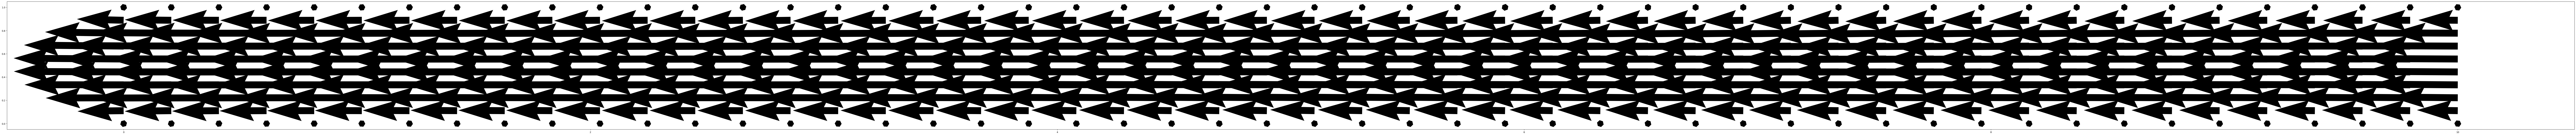

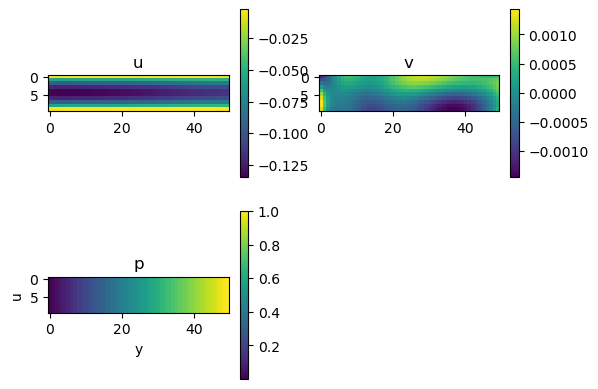

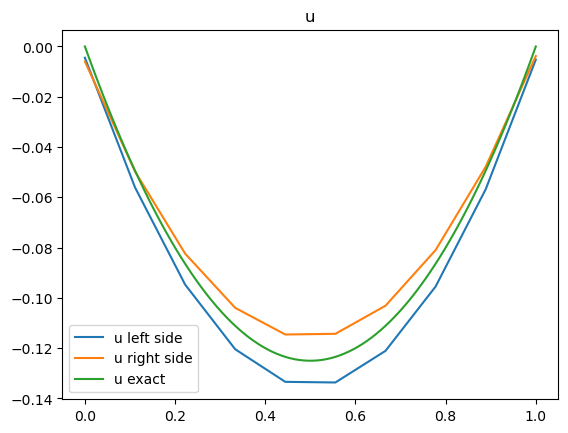

In [9]:
# make grid for test
t_test=np.zeros(1)
x_test=np.linspace(0,10.0,50)
y_test=np.linspace(0,1.0,10)
t_test_m,x_test_m, y_test_m=np.meshgrid(t_test,x_test,y_test)
t_test_m=np.reshape(t_test_m,(500,1))
x_test_m=np.reshape(x_test_m,(500,1))
y_test_m=np.reshape(y_test_m,(500,1))
pt_t_test= Variable(torch.from_numpy(t_test_m).float(), requires_grad=True).to(device)
pt_x_test= Variable(torch.from_numpy(x_test_m).float(), requires_grad=True).to(device)
pt_y_test= Variable(torch.from_numpy(y_test_m).float(), requires_grad=True).to(device)

#run model
psi=model(pt_t_test,pt_x_test,pt_y_test)[:,0]
p=model(pt_t_test,pt_x_test,pt_y_test)[:,1]

# calculate u and v from psi
u = torch.autograd.grad(psi.sum(), pt_y_test, create_graph=True)[0]
v = -torch.autograd.grad(psi.sum(), pt_x_test, create_graph=True)[0]

#plot results
fig=plt.gcf()
fig.set_size_inches(200,10)
plt.quiver(x_test_m,y_test_m,u.detach().numpy().reshape((50,10)),v.detach().numpy().reshape((50,10)))
plt.show()
plt.subplot(2,2,1)
plt.imshow(u.detach().numpy().reshape((50,10)).T)
plt.title('u')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(v.detach().numpy().reshape((50,10)).T)
plt.title('v')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(p.detach().numpy().reshape((50,10)).T)
plt.title('p')
plt.colorbar()

plt.xlabel('y')
plt.ylabel('u')
plt.show()
plt.title('u')
plt.plot(np.linspace(0,1,10),u.detach().numpy().reshape((50,10))[0,:])
plt.plot(np.linspace(0,1,10),u.detach().numpy().reshape((50,10))[-1,:])
plt.plot(np.linspace(0,1,100),(np.linspace(0,1,100)-0.5)**2*0.5-0.125)
plt.legend(['u left side','u right side', 'u exact'])

In [53]:
torch.save(model.state_dict(),"model4.pt")